# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [46]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [47]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [181]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(y = r_0, x = 0 * m,
             vx = -30330 * m / s, vy = -10000 * m/s)

,values
y,147000000000.0 meter
x,0 meter
vx,-30330.0 meter / second
vy,-10000.0 meter / second


In [182]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,y 147000000000.0 meter x ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [183]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vy, vx = state
    unpack(system)
    
    direction= Vector(-x,-y) *m
    force = (G * m1 * m2 )/ (x**2 + y**2)
    gravity = force * direction.hat()

    return gravity


In [184]:
universal_gravitation(init, system)

<Quantity([-3.6686486e+22  0.0000000e+00], 'newton')>

In [185]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, x, vx, vy = state
    unpack(system)    

    force = universal_gravitation(state, system)
    
    v = Vector(vx, vy)
    dxdt = vx
    dydt = vy
    dvxdt = force[0] / m2
    dvydt = force[1] /m2
    
    
    return dxdt, dydt, dvxdt, dvydt 

In [186]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(-30330.0, 'meter / second')>,
 <Quantity(-10000.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(0.0, 'newton / kilogram')>)

In [187]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    x, y, vx, vy = state
    return r - system.r_final

In [188]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,218
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [189]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(10000000.0, 'second')>

In [190]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(115.74074074074072, 'day')>

In [191]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, t_eval=ts)

In [192]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [193]:
# Scaling the distance to million km

y = results.y / 1e9;
x = results.x/1e9

0.000000        0.000000
0.578704       -0.499991
1.157407       -0.999928
1.736111       -1.499754
2.314815       -1.999401
2.893519       -2.498534
3.472222       -2.997035
4.050926       -3.494955
4.629630       -3.992323
5.208333       -4.489147
5.787037       -4.985410
6.365741       -5.481076
6.944444       -5.976085
7.523148       -6.470355
8.101852       -6.963781
8.680556       -7.456238
9.259259       -7.947576
9.837963       -8.437625
10.416667      -8.926192
10.995370      -9.413060
11.574074      -9.897994
12.152778     -10.380731
12.731481     -10.860992
13.310185     -11.338470
13.888889     -11.812840
14.467593     -12.283753
15.046296     -12.750837
15.625000     -13.213699
16.203704     -13.671924
16.782407     -14.125074
                 ...    
98.958333     116.497473
99.537037     116.748163
100.115741    116.994646
100.694444    117.236975
101.273148    117.475200
101.851852    117.709372
102.430556    117.939539
103.009259    118.165747
103.587963    118.388043


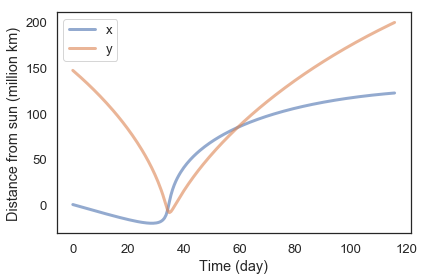

In [194]:
# And plotting

plot(x, label='x')
plot(y, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')